In [16]:
%pylab inline

import pandas as pd
import nltk
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, jaccard_score

Populating the interactive namespace from numpy and matplotlib


In [ ]:
#---------------------#

In [ ]:
# Loading data

In [2]:
df_clean = pd.read_csv('df_clean_51k.csv')
df_clean.tags_clean = df_clean.tags_clean.apply(lambda x: x.replace('[', '').replace(']', '').replace("'", '').replace(" ", '').split(','))

In [ ]:
#---------------------#

In [ ]:
# LDA Model

In [3]:
# tf-idf
tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df=0.01, ngram_range=(1, 2))

x_tfidf = tfidf_vectorizer.fit_transform(df_clean.Title_and_Body_cleaned)
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

len(tfidf_feature_names)

701

In [4]:
lda = LatentDirichletAllocation(n_components=15, learning_method='online', learning_decay=0.7, learning_offset=100, random_state=0)
lda.fit(x_tfidf)

LatentDirichletAllocation(learning_method='online', learning_offset=100,
                          n_components=15, random_state=0)

In [6]:
def topic_table(n_top_words, feature_names, model):
  topics = {}
  for i, topic_vec in enumerate(model.components_):
    topic_descr = ''
    for fid in topic_vec.argsort()[-1:-n_top_words-1:-1]:
      topic_descr = topic_descr + feature_names[fid] + " "
    topics[i] = topic_descr
  return pd.DataFrame({'Top_Topic_Terms': topics})

In [7]:
# Label topics with top 5 terms
topic_df = topic_table(5, tfidf_feature_names, lda)
topic_df

,Top_Topic_Terms
0,request api async await return
1,type function class object return
2,column dataframe row value df
3,git github commit branch repository
4,react component render const gt
5,model tensorflow difference use import
6,run error build file docker
7,string file print output code
8,plot date month day year
9,view swiftui button android var


In [ ]:
#---------------------#

In [ ]:
# Topics -> Feature vectors

In [8]:
list_topics_probability = []
for i in range(len(df_clean.Title_and_Body_cleaned)):
    list_topics_probability.append(lda.transform(tfidf_vectorizer.transform([df_clean.Title_and_Body_cleaned[i]]))[0])

df_proba_topics = pd.DataFrame(data=list_topics_probability)

In [9]:
df_proba_topics

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0.016501,0.016501,0.768979,0.016501,0.016501,0.016502,0.016501,0.016502,0.016501,0.016501,0.016502,0.016501,0.016501,0.016502,0.016501
1,0.009560,0.009560,0.009560,0.237379,0.009560,0.009560,0.009560,0.009560,0.009560,0.009560,0.009560,0.009560,0.638344,0.009560,0.009560
2,0.016222,0.016222,0.016222,0.016222,0.016222,0.016222,0.016222,0.016222,0.016222,0.016222,0.772887,0.016223,0.016222,0.016222,0.016222
3,0.014802,0.014802,0.014802,0.792769,0.014802,0.014802,0.014802,0.014802,0.014802,0.014802,0.014802,0.014802,0.014802,0.014802,0.014802
4,0.009468,0.009468,0.571235,0.009468,0.009468,0.009468,0.009468,0.009468,0.009468,0.009468,0.305682,0.009468,0.009468,0.009468,0.009468
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51339,0.015832,0.015832,0.015832,0.015832,0.015832,0.015832,0.015832,0.778349,0.015832,0.015832,0.015832,0.015832,0.015832,0.015832,0.015832
51340,0.009918,0.009918,0.009918,0.009918,0.009918,0.009918,0.861151,0.009918,0.009918,0.009918,0.009918,0.009918,0.009918,0.009918,0.009918
51341,0.592236,0.012676,0.012676,0.012676,0.012676,0.012676,0.012676,0.012676,0.012676,0.012676,0.242977,0.012676,0.012676,0.012676,0.012676
51342,0.011096,0.042729,0.813032,0.011095,0.011095,0.011095,0.011096,0.011095,0.011095,0.011095,0.011095,0.011096,0.011099,0.011095,0.011095


In [ ]:
#---------------------#

In [ ]:
# Semi-supervised model

In [10]:
# Target (tags) encoding
mlb = MultiLabelBinarizer()
mlb.fit(df_clean['tags_clean'])

# Target encoded decoding
le = LabelEncoder()
le.fit(mlb.classes_)

LabelEncoder()

In [13]:
# We are creating a train_set and a test_set

x_train, x_test, y_train, y_test = train_test_split(df_proba_topics, mlb.transform(df_clean.tags_clean), random_state=0)

In [17]:
# we are using a logReg model
# with the results of the LDA algorithm

param_grid_logReg = {
    'estimator__C': np.logspace(-1, 1, 3)
}

model_logReg = GridSearchCV(
    OneVsRestClassifier(
        LogisticRegression(
            max_iter=1000,
            class_weight='balanced',
            multi_class='ovr'
        )
    ),
    param_grid_logReg,
    scoring='neg_log_loss',
    cv=3
)

model_logReg.fit(x_train, y_train)

GridSearchCV(cv=3,
             estimator=OneVsRestClassifier(estimator=LogisticRegression(class_weight='balanced',
                                                                        max_iter=1000,
                                                                        multi_class='ovr')),
             param_grid={'estimator__C': array([ 0.1,  1. , 10. ])},
             scoring='neg_log_loss')

In [18]:
print('Best score: {:.2f}'.format(model_logReg.best_score_))
print('Best parameters: ', model_logReg.best_params_)

Best score: -11.04
Best parameters:  {'estimator__C': 1.0}


In [ ]:
#---------------------#

In [ ]:
# F1 and Jaccard score

In [19]:
def create_liste_result_f1_jaccard(x, model, threshold):
    y_pred = model.predict_proba(x)

    liste_result_y_pred = []

    for index in range(len(y_pred)):
        result_y_pred = [0] * len(y_pred[index])
        tmp_y_pred = [a for a, b in enumerate(y_pred[index]) if b >= threshold]

        for i in range(len(tmp_y_pred)):
            result_y_pred[tmp_y_pred[i]] = 1

        liste_result_y_pred.append(result_y_pred)

    return(liste_result_y_pred)

In [20]:
def f1_jaccard_graph(x, y, model):

    result_threshold = []
    result_f1 = []
    result_jaccard = []

    for i in range(0, 50, 1):
        seuil = i/50
        liste_result_y_pred = create_liste_result_f1_jaccard(x, model, seuil)

        result_threshold.append(seuil)
        result_f1.append(f1_score(y, liste_result_y_pred, average='weighted'))
        result_jaccard.append(jaccard_score(y, liste_result_y_pred, average='weighted'))

    fig, ax1 = plt.subplots(figsize=(10, 7))

    color = 'tab:red'
    ax1.set_xlabel('Threshold')
    ax1.set_ylabel('F1 score (weighted)', color=color)
    ax1.plot(result_threshold, result_f1, color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    # instantiate a second axes that shares the same x-axis
    ax2 = ax1.twinx()

    color = 'tab:blue'
    # we already handled the x-label with ax1
    ax2.set_ylabel('Jaccard score (weighted)', color=color)
    ax2.plot(result_threshold, result_jaccard, color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    # otherwise the right y-label is slightly clipped
    fig.tight_layout()
    plt.show()

C:\Users\maude\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1464: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(
C:\Users\maude\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\maude\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1464: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(
C:\Users\maude\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in lab

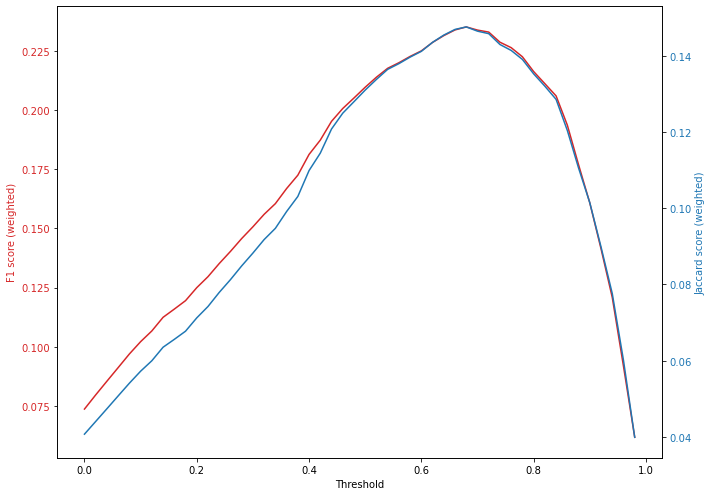

In [21]:
# F1, jaccard -> average = weighted
f1_jaccard_graph(x_test[:5000], y_test[:5000], model_logReg)

In [24]:
# The max (for F1 and Jaccard scores) is near to a threshold ~ 0.9
def max_scores(x, y, model):

    result_threshold = []
    result_f1 = []
    result_jaccard = []

    # Thnaks to the graph, we know that the max of Jaccard score
    # is given by a threshold > 0.50
    for i in range(50, 100, 1):
        seuil = i/100
        liste_result_y_pred = create_liste_result_f1_jaccard(x, model, seuil)

        result_threshold.append(seuil)
        result_jaccard.append(jaccard_score(y, liste_result_y_pred, average='weighted'))
        result_f1.append(f1_score(y, liste_result_y_pred, average='weighted'))

    # we want to maximize the Jaccard score:
    index = result_jaccard.index(max(result_jaccard))

    return(
        result_threshold[index],
        result_jaccard[index],
        result_f1[index]
    )

In [26]:
threshold, jaccard, f1 = max_scores(x_test[:5000], y_test[:5000], model_logReg)

C:\Users\maude\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\maude\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1464: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(
C:\Users\maude\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\maude\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1464: UndefinedMetricWarning: F-score i

In [27]:
print("Threshold = ", threshold)
print("\nScores (average == weighted):\n")
print("Jaccard score    = {:.2f}".format(jaccard))
print("F1 score         = {:.2f}".format(f1))

Threshold =  0.67

Scores (average == weighted):

Jaccard score    = 0.15
F1 score         = 0.24


In [ ]:
'''
For the supervised model, we had :
    Jaccard score (weighted) = 0.38
    F1 score (weighted)      = 0.52

The supervised model is still better than the semi-supervised model.
'''

In [ ]:
#---------------------#

In [ ]:
# Test the tags prediction with some sentences

In [ ]:
# Threshold = 0.67 gives too much tags
# we will try threshold = 0.92

In [28]:
new_review1 = ['Hello! I want to create a model, which can give the tags of a sentence or question. Besides, I have to try both supervised and unsupervised machine learning algorithms. Do you know some python librairies, which can help building fast models?']

new_review2_title = ["Finding duplicate values in a SQL table"]
new_review2 = ["It's easy to find duplicates with one field. So if we have a table. This query will give us John, Sam, Tom, Tom because they all have the same email. However, what I want is to get duplicates with the same email and name. That is, I want to get 'Tom', 'Tom'. The reason I need this: I made a mistake, and allowed to insert duplicate name and email values. Now I need to remove/change the duplicates, so I need to find them first."]

new_review3_title = ["How to make several plots on a single page using matplotlib?"]
new_review3 = ["I have written code that opens 16 figures at once. Currently they all open as separate graphs. I'd like them to open all on the same page. Not the same graph. I want 16 separate graphs on a single page/window. Also for some reason the format of the numbins and defaultreallimits doesn't hold past figure 1. Do I need to use the subplot command? I don't understand why I would have to but can't figure out what else I would do?"]

In [44]:
question = new_review1

array = model_logReg.predict_proba(lda.transform(tfidf_vectorizer.transform(question))[0].reshape((1, 15)))

threshold = 0.92

print(le.inverse_transform([i for i, j in enumerate(array[0]) if j >= threshold]))

['deep-learning' 'keras' 'machine-learning' 'memory' 'multithreading'
 'neural-network' 'pytorch' 'scikit-learn' 'tensorflow' 'tensorflow2.0']


In [45]:
question = new_review2

array = model_logReg.predict_proba(lda.transform(tfidf_vectorizer.transform(question))[0].reshape((1, 15)))

threshold = 0.92

print(le.inverse_transform([i for i, j in enumerate(array[0]) if j >= threshold]))

['database' 'mysql' 'oracle' 'sql' 'sql-server' 'sqlite']


In [43]:
question = new_review3

array = model_logReg.predict_proba(lda.transform(tfidf_vectorizer.transform(question))[0].reshape((1, 15)))

threshold = 0.92

print(le.inverse_transform([i for i, j in enumerate(array[0]) if j >= threshold]))

['beautifulsoup' 'google-apps-script' 'google-chrome'
 'google-colaboratory' 'google-sheets' 'pdf' 'powershell'
 'python-requests' 'selenium' 'selenium-chromedriver' 'selenium-webdriver'
 'web-scraping']
